# Player Passing Clusters Analysis

This notebook analyzes the passing patterns of individual players using different clustering strategies. We'll:
1. Load the valued actions data
2. Select a specific team
3. View all players from that team
4. Choose a player to analyze
5. Cluster their passes using different strategies

## 1. Data Loading and Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from matplotlib.patches import Patch
from mplsoccer import VerticalPitch
from sklearn.cluster import AgglomerativeClustering
import warnings

## 2. Load and Prepare Data

In [2]:
print("Loading data...")
warnings.filterwarnings('ignore')

competition_id = 2

with pd.HDFStore('data/spadl-statsbomb.h5') as store:
    competitions = store['competitions']
    competition_id_2 = competitions[competitions['competition_id'] == competition_id]
    
    if len(competition_id_2) == 0:
        raise ValueError(f"No data found for competition_id == {competition_id}")
    
    games = store['games']
    games = games[games['competition_id'] == 2]
    
    # Load teams and players
    teams = store['teams']
    players = store['players']
    player_games = store['player_games']
    
    actions_list = []
    for game_id in games['game_id']:
        try:
            game_actions = store[f'actions/game_{game_id}']
            actions_list.append(game_actions)
        except KeyError:
            continue
    
    if not actions_list:
        raise ValueError("No actions found for competition_id == 2")
    
    actions = pd.concat(actions_list)

valued_actions = pd.read_hdf('data/valued_actions.h5', key='valued_actions')

valued_actions = valued_actions[valued_actions['game_id'].isin(games['game_id'])]

competition_players = (
    player_games[player_games['game_id'].isin(games['game_id'])]
    [['player_id', 'team_id']]
    .drop_duplicates()
    .merge(players[['player_id', 'player_name']], on='player_id')
    .merge(teams[['team_id', 'team_name']], on='team_id')
    .sort_values(by='player_name')
    .reset_index(drop=True)
)

Loading data...


## 3. Team Selection

In [3]:
team_display = teams[teams['team_id'].isin(competition_players['team_id'])].copy()
team_display = team_display[['team_id', 'team_name']].drop_duplicates().sort_values('team_name')

print("Times disponíveis:")
for _, row in team_display.iterrows():
    print(f"{row['team_name']}")


Times disponíveis:
AFC Bournemouth
Arsenal
Aston Villa
Chelsea
Crystal Palace
Everton
Leicester City
Liverpool
Manchester City
Manchester United
Newcastle United
Norwich City
Southampton
Stoke City
Sunderland
Swansea City
Tottenham Hotspur
Watford
West Bromwich Albion
West Ham United


In [4]:
selected_team_name = "Liverpool"

team_id = team_display.loc[team_display['team_name'] == selected_team_name, 'team_id'].values[0]

print(f"Time selecionado: {selected_team_name} (ID: {team_id})")


Time selecionado: Liverpool (ID: 24)


## 4. Player Selection

In [5]:
team_players = competition_players[competition_players['team_id'] == team_id]
team_players = team_players[['player_id', 'player_name']].drop_duplicates().sort_values('player_name')

print(f"\nJogadores disponíveis do {selected_team_name}:")
for _, row in team_players.iterrows():
    print(f"{row['player_name']}")



Jogadores disponíveis do Liverpool:
Adam David Lallana
Alberto Moreno Pérez
Bradley Shaun Smith
Cameron Brannagan
Christian Benteke Liolo
Connor Steven Randall
Daniel Andre Sturridge
Daniel William John Ings
Danny Ward
Dejan Lovren
Divock Okoth Origi
Emre Can
James Philip Milner
Joe Allen
Joe Gomez
Jon Flanagan
Jordan Brian Henderson
Jordan Rossiter
Jordon Ibe
João Carlos Vilaça Teixeira
Kevin Linford Stewart
Kolo Habib Touré
Lucas Pezzini Leiva
Mamadou Sakho
Martin Škrtel
Nathaniel Edwin Clyne
Oluwaseyi Babajide Ojo
Pedro Chirivella Burgos
Philippe Coutinho Correia
Roberto Firmino Barbosa de Oliveira
Sergi Canós Tenes
Simon Mignolet
Steven Caulker
Ádám Bogdán


In [6]:
selected_player_name = "Philippe Coutinho Correia"

player_id = team_players.loc[team_players['player_name'] == selected_player_name, 'player_id'].values[0]

print(f"Jogador selecionado: {selected_player_name} (ID: {player_id})")


Jogador selecionado: Philippe Coutinho Correia (ID: 3501)


## 5. Pass Clustering Analysis

In [7]:
player_passes = valued_actions[
                (valued_actions['type_name'] == 'pass')
                & (valued_actions['player_id'] == player_id)]


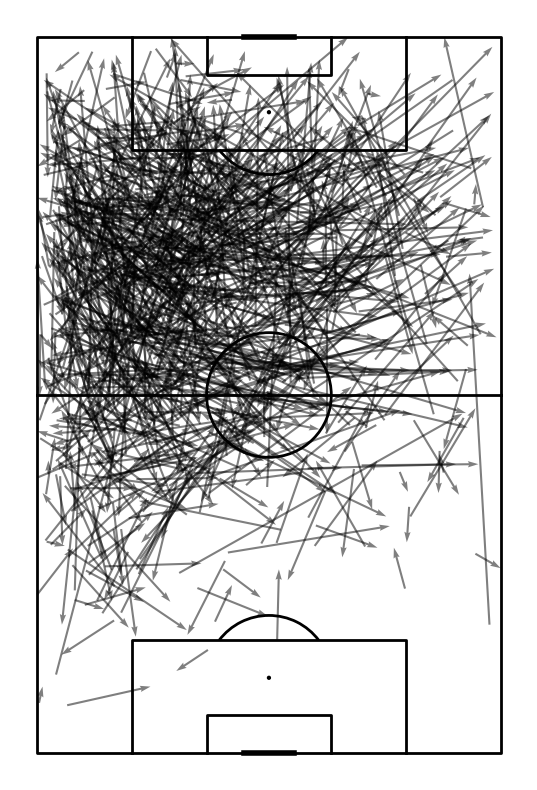

In [8]:
pitch = VerticalPitch(pitch_type='custom', pitch_length=105, pitch_width=68,
                      line_color='black')
fig, ax = pitch.draw(figsize=(12, 8))

pitch.arrows(player_passes['start_x'], player_passes['start_y'],
                player_passes['end_x'], player_passes['end_y'],
                color='black',
                alpha=0.5, width=1.5, headwidth=3, ax=ax)

plt.savefig('naive_passes.png', dpi=200)

### 5.1 k-means Clustering

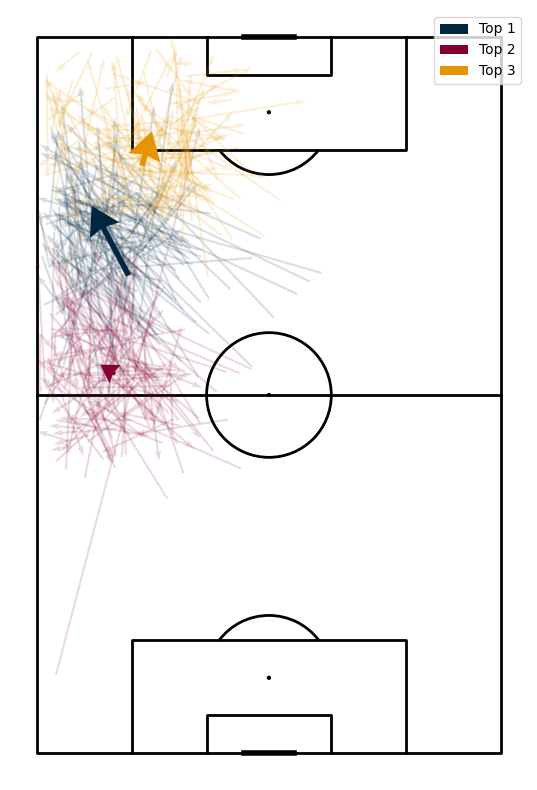

In [9]:
X = player_passes[['start_x', 'start_y', 'end_x', 'end_y']]
kmeans = KMeans(n_clusters=10, random_state=42)
player_passes['cluster'] = kmeans.fit_predict(X)

top_clusters = player_passes['cluster'].value_counts().head(3).index.tolist()

filtered_passes = player_passes[player_passes['cluster'].isin(top_clusters)]

pitch = VerticalPitch(pitch_type='custom', pitch_length=105, pitch_width=68,
                      line_color='black')
fig, ax = pitch.draw(figsize=(12, 8))


purple_shades = ['#002642', '#840032','#e59500']
cluster_color_map = dict(zip(top_clusters, purple_shades))

for cluster_id in top_clusters:
    cluster_data = filtered_passes[filtered_passes['cluster'] == cluster_id]
    pitch.arrows(cluster_data['start_x'], cluster_data['start_y'],
                 cluster_data['end_x'], cluster_data['end_y'],
                 color=cluster_color_map[cluster_id],
                 alpha=0.15, width=1.5, headwidth=3, ax=ax)

legend_elements = []
for i, cluster_id in enumerate(top_clusters):
    cluster_data = filtered_passes[filtered_passes['cluster'] == cluster_id]
    mean_start_x = cluster_data['start_x'].mean()
    mean_start_y = cluster_data['start_y'].mean()
    mean_end_x = cluster_data['end_x'].mean()
    mean_end_y = cluster_data['end_y'].mean()

    pitch.arrows(mean_start_x, mean_start_y,
                 mean_end_x, mean_end_y,
                 color=cluster_color_map[cluster_id], lw=6,
                 width=4, headwidth=6, ax=ax)

    legend_elements.append(Patch(facecolor=cluster_color_map[cluster_id], label=f'Top {i+1}'))

plt.legend(handles=legend_elements, loc='upper right')
plt.savefig('kmeans.png', dpi=200)


### 5.2 Agglomerative Clustering

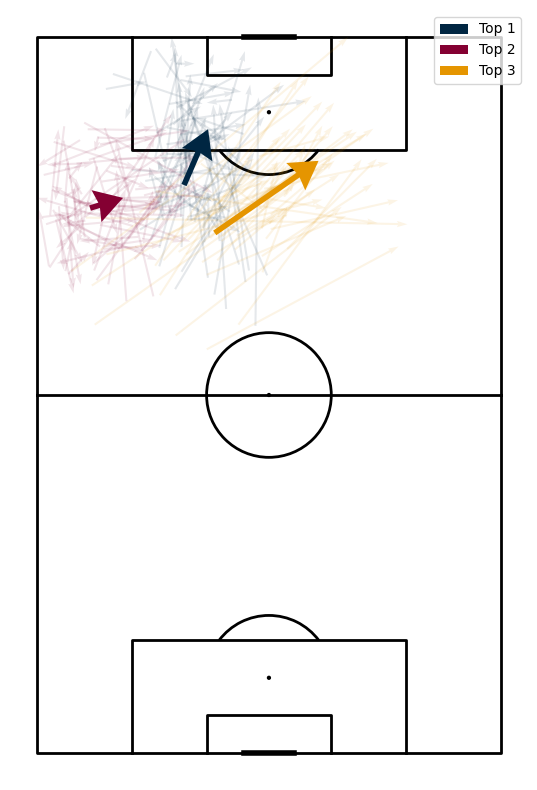

In [10]:
player_passes['distancia'] = np.sqrt(
    (player_passes['end_x'] - player_passes['start_x'])**2 +
    (player_passes['end_y'] - player_passes['start_y'])**2
)
filtered_df = player_passes

X = filtered_df[['start_x', 'start_y', 'end_x', 'end_y']].values

clustering = AgglomerativeClustering(
    n_clusters=None,
    distance_threshold=100,
    compute_full_tree=True,
    affinity='euclidean',
    linkage='ward'
    )
filtered_df['cluster'] = clustering.fit_predict(X)

cluster_stats = (
    filtered_df.groupby('cluster')
    .agg(soma_vaep=('vaep_value', 'sum'),
         qnt_passes=('cluster', 'size'))
    .reset_index()
)
cluster_stats['rank_vaep'] = cluster_stats['soma_vaep'].rank(method='dense', ascending=False)
cluster_stats['rank_passes'] = cluster_stats['qnt_passes'].rank(method='dense', ascending=False)
cluster_stats['rank_final'] = (cluster_stats['rank_vaep'] + cluster_stats['rank_passes']) / 2
top_clusters = cluster_stats.sort_values('rank_final')['cluster'].head(3).tolist()

filtered_passes = filtered_df[filtered_df['cluster'].isin(top_clusters)]

pitch = VerticalPitch(pitch_type='custom', pitch_length=105, pitch_width=68,
                      line_color='black')
fig, ax = pitch.draw(figsize=(12, 8))

purple_shades = ['#002642', '#840032','#e59500']
cluster_color_map = dict(zip(top_clusters, purple_shades))

for cluster_id in top_clusters:
    cluster_data = filtered_passes[filtered_passes['cluster'] == cluster_id]
    pitch.arrows(cluster_data['start_x'], cluster_data['start_y'],
                 cluster_data['end_x'], cluster_data['end_y'],
                 color=cluster_color_map[cluster_id],
                 alpha=0.1, width=1.5, headwidth=3, ax=ax)

legend_elements = []
for i, cluster_id in enumerate(top_clusters):
    cluster_data = filtered_passes[filtered_passes['cluster'] == cluster_id]
    mean_start_x = cluster_data['start_x'].mean()
    mean_start_y = cluster_data['start_y'].mean()
    mean_end_x = cluster_data['end_x'].mean()
    mean_end_y = cluster_data['end_y'].mean()

    pitch.arrows(mean_start_x, mean_start_y,
                 mean_end_x, mean_end_y,
                 color=cluster_color_map[cluster_id], lw=6,
                 width=4, headwidth=6, ax=ax)

    legend_elements.append(Patch(facecolor=cluster_color_map[cluster_id], label=f'Top {i+1}'))

plt.legend(handles=legend_elements, loc='upper right') 
plt.savefig('agg_clustering.png', dpi=200)
